In [96]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [97]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.6.0



In [98]:
# Path to the extracted dataset
data_dir = r"D:\food-101\food-101\food-101\images"
meta_dir = r"D:\food-101\food-101\food-101\meta"



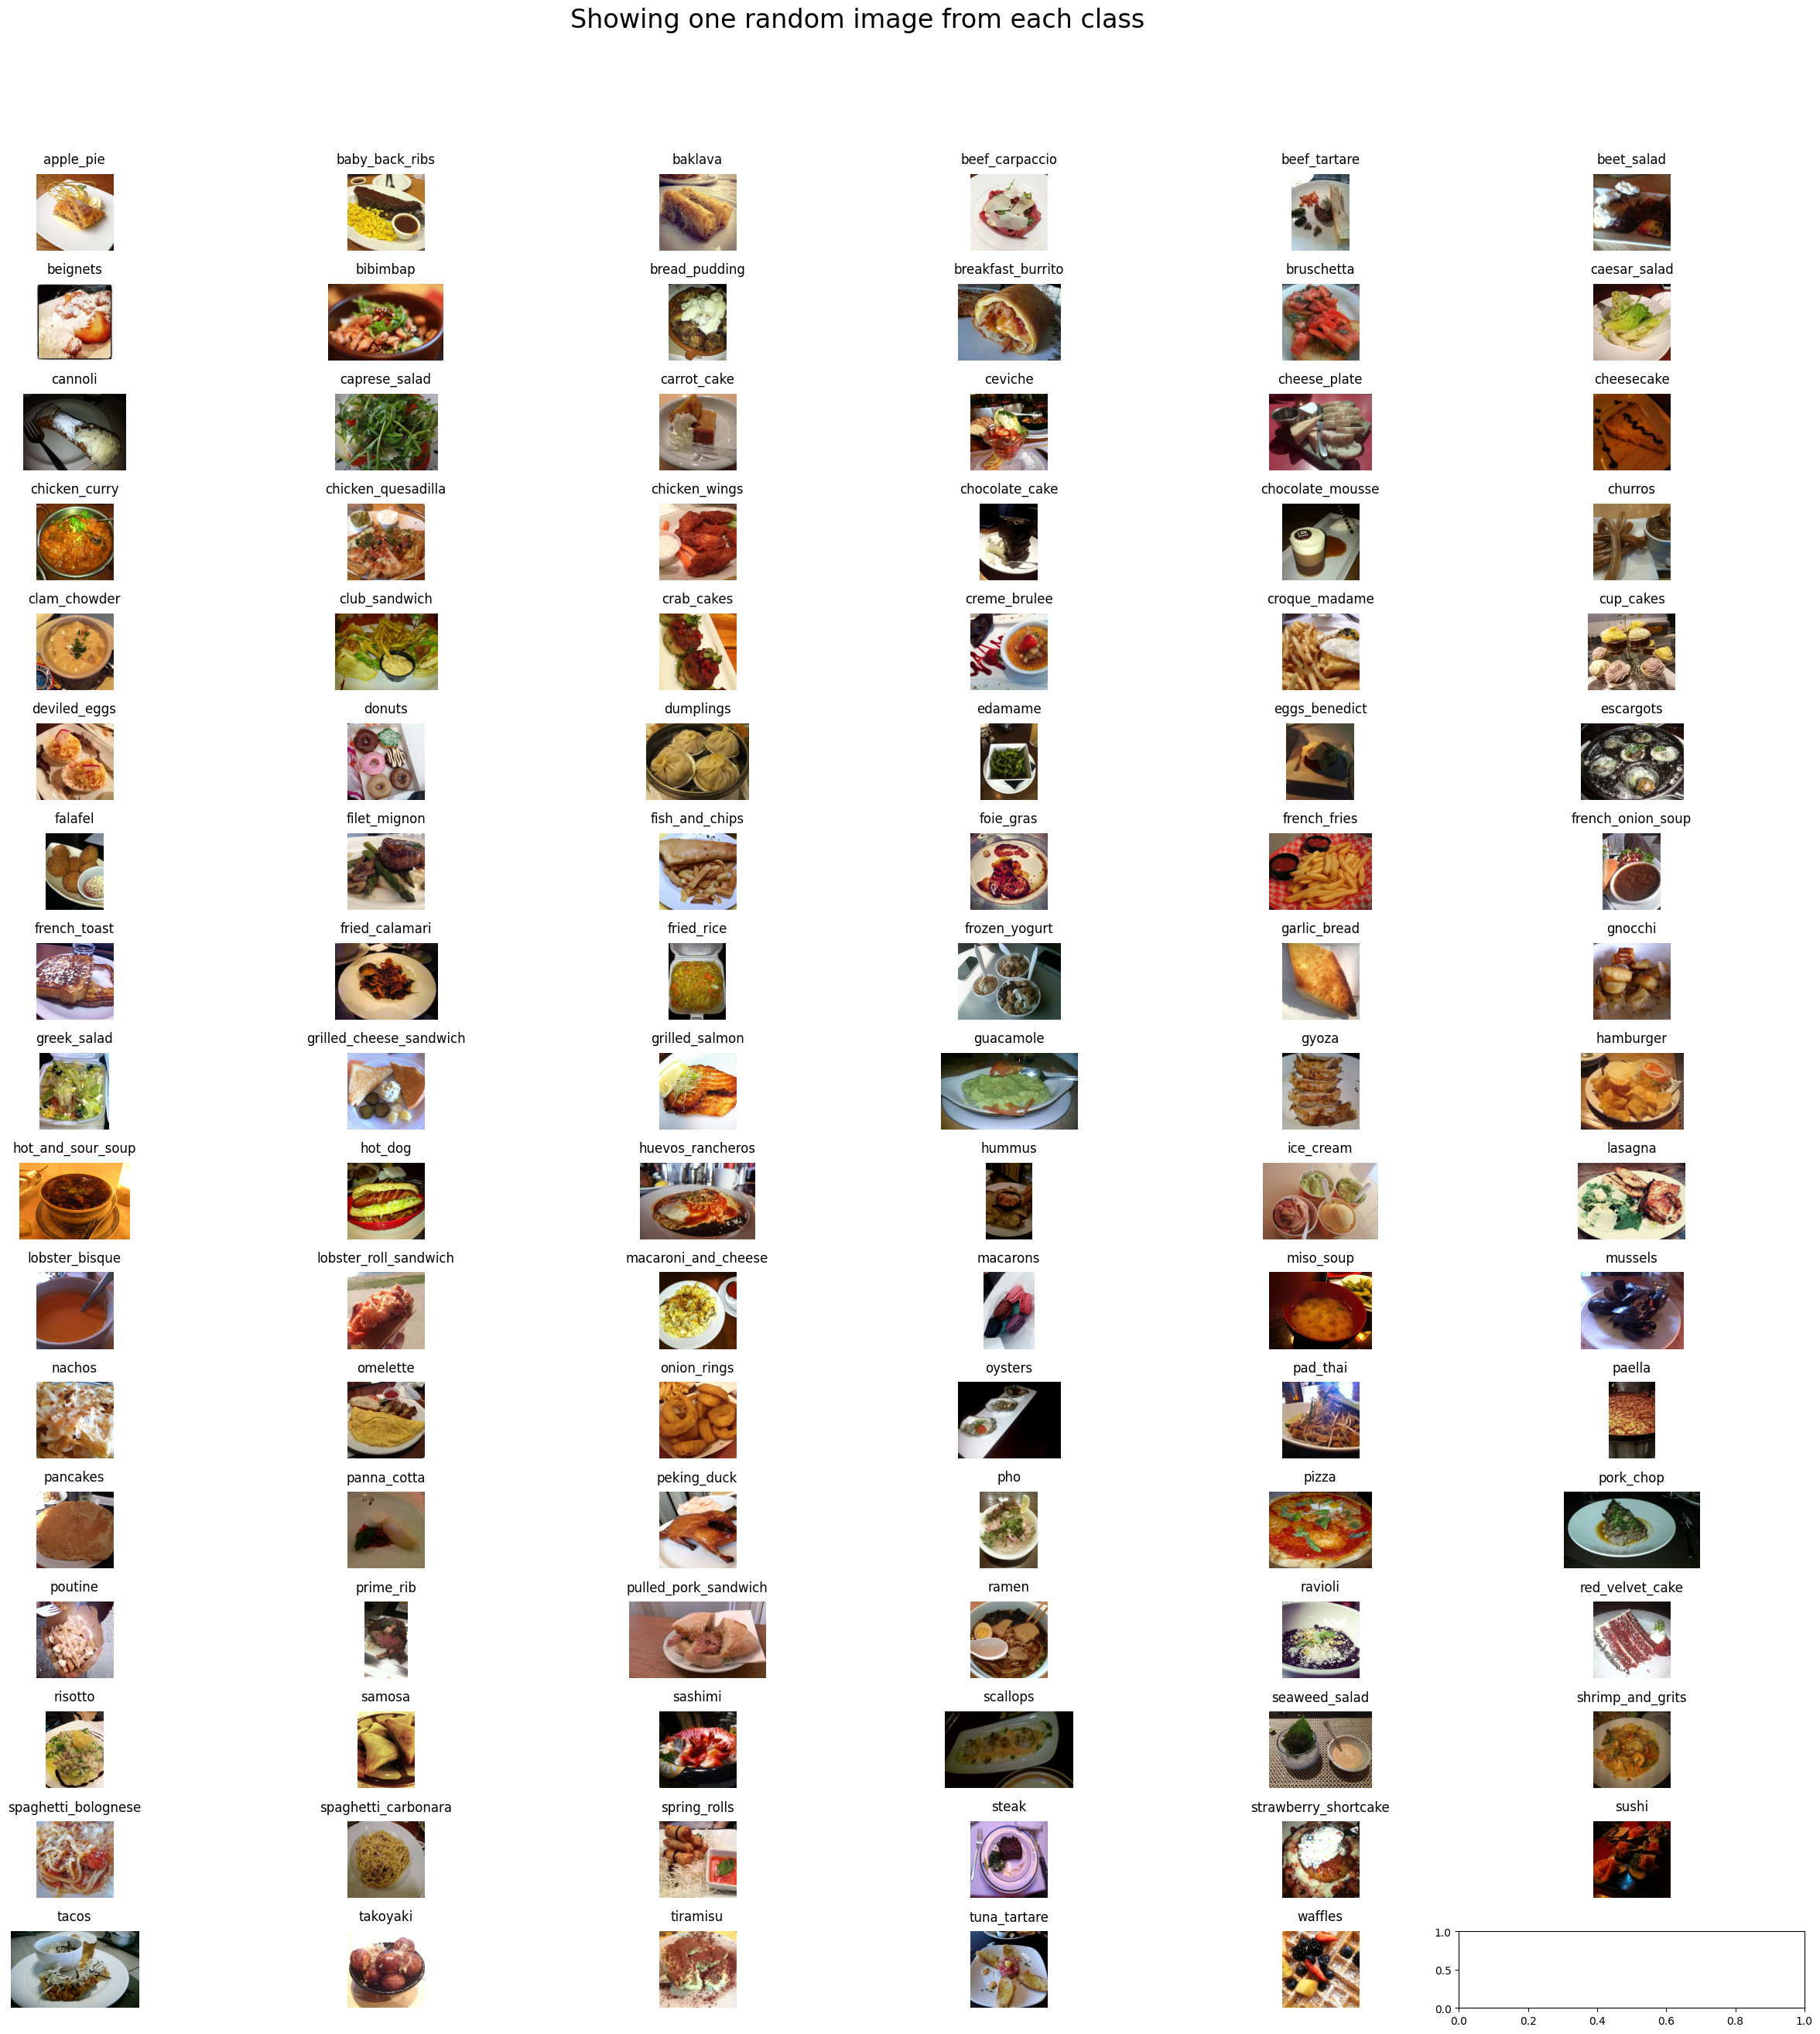

In [99]:
# Function to visualize random images from each of the 101 classes
def visualize_food_images():
    rows = 17
    cols = 6
    fig, ax = plt.subplots(rows, cols, figsize=(25, 25))
    fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24)

    # Get sorted list of food categories
    foods_sorted = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))])
    food_id = 0

    for i in range(rows):
        for j in range(cols):
            if food_id >= len(foods_sorted):
                break
            food_selected = foods_sorted[food_id]
            food_id += 1
            
            # Get random image from selected food category
            food_selected_images = os.listdir(os.path.join(data_dir, food_selected))
            food_selected_random = np.random.choice(food_selected_images)
            img_path = os.path.join(data_dir, food_selected, food_selected_random)
            
            img = plt.imread(img_path)
            ax[i][j].imshow(img)
            ax[i][j].set_title(food_selected, pad=10)
            ax[i][j].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display the images
visualize_food_images()

In [100]:

# Helper function to split dataset into train and test folders
def prepare_data(filepath, src, dest):
    """
    Helper function to organize images into respective train and test folders based on file paths.

    Parameters:
    filepath (str): Path to the text file (train.txt or test.txt) listing image paths.
    src (str): Source directory where all images are located.
    dest (str): Destination directory where images will be copied, organized by class.
    """
    classes_images = defaultdict(list)
    
    # Read the paths from the provided text file
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        
        # Organize the paths by class
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')
    
    # Copy images into respective class folders
    for food_class in classes_images.keys():
        print(f"\nCopying images into {food_class}")
        
        # Create the destination class folder if it doesn't exist
        class_folder = os.path.join(dest, food_class)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)
        
        # Copy each image into the corresponding class folder in the destination
        for image in classes_images[food_class]:
            src_image_path = os.path.join(src, food_class, image)
            dest_image_path = os.path.join(dest, food_class, image)
            copy(src_image_path, dest_image_path)
    
    print("Copying Done!")

# Prepare train dataset by copying images from food-101/images to train folder
print("Creating train data...")
train_meta_path = r"D:\food-101\food-101\food-101\meta\train.txt"
image_source = r"D:\food-101\food-101\food-101\images"
train_dest = r"D:\food-101\train"
prepare_data(train_meta_path, image_source, train_dest)

# Prepare test dataset by copying images from food-101/images to test folder
print("Creating test data...")
test_meta_path = r"D:\food-101\food-101\food-101\meta\test.txt"
test_dest = r"D:\food-101\test"
prepare_data(test_meta_path, image_source, test_dest)

# Check the total number of files in the train folder
print("Total number of samples in train folder")
train_count = sum([len(files) for _, _, files in os.walk(train_dest)])
print(train_count)

# Check the total number of files in the test folder
print("Total number of samples in test folder")
test_count = sum([len(files) for _, _, files in os.walk(test_dest)])
print(test_count)

    


Creating train data...

Copying images into apple_pie

Copying images into baby_back_ribs

Copying images into baklava

Copying images into beef_carpaccio

Copying images into beef_tartare

Copying images into beet_salad

Copying images into beignets

Copying images into bibimbap

Copying images into bread_pudding

Copying images into breakfast_burrito

Copying images into bruschetta

Copying images into caesar_salad

Copying images into cannoli

Copying images into caprese_salad

Copying images into carrot_cake

Copying images into ceviche

Copying images into cheesecake

Copying images into cheese_plate

Copying images into chicken_curry

Copying images into chicken_quesadilla

Copying images into chicken_wings

Copying images into chocolate_cake

Copying images into chocolate_mousse

Copying images into churros

Copying images into clam_chowder

Copying images into club_sandwich

Copying images into crab_cakes

Copying images into creme_brulee

Copying images into croque_madame

Cop

In [101]:
import os
from shutil import rmtree, copytree

# Define the path to the images directory and get sorted food categories
data_dir = r"D:\food-101\food-101\food-101\images"  # Adjust this path according to your directory
foods_sorted = sorted(os.listdir(data_dir))

# Remove any hidden files, like .DS_Store, that might be in the list
foods_sorted = [food for food in foods_sorted if not food.startswith('.')]

# Remove the first element if it's a hidden file (like .DS_Store)
if foods_sorted and foods_sorted[0] == '.DS_Store':
    del foods_sorted[0]

# Helper method to create mini versions of train and test datasets
def dataset_mini(food_list, src, dest):
    """
    Copies specified food classes into a mini dataset directory.

    Parameters:
    food_list (list): List of food class names to include in the mini dataset.
    src (str): Source directory where full dataset classes are located.
    dest (str): Destination directory for the mini dataset.
    """
    # Remove existing mini dataset directory if it exists
    if os.path.exists(dest):
        rmtree(dest)
    
    # Create the destination directory
    os.makedirs(dest)
    
    # Copy each specified food class folder to the destination directory
    for food_item in food_list:
        print("Copying images into", food_item)
        copytree(os.path.join(src, food_item), os.path.join(dest, food_item))
    
    print("Mini dataset creation complete!")

# Define source and destination paths
src_train = data_dir  # Assuming train images are in data_dir
dest_train = r"D:\food-101\food-101\mini_dataset\train_mini"  # Adjust destination path
src_test = data_dir  # Assuming test images are in data_dir
dest_test = r"D:\food-101\food-101\mini_dataset\test_mini"  # Adjust destination path

# Define the food items for the mini dataset
food_list = ['apple_pie', 'pizza', 'omelette']

# Create the mini dataset for training
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

# Count total number of samples in train folder
total_train_samples = sum(len(files) for _, _, files in os.walk(dest_train))
print("Total number of samples in train folder:", total_train_samples)

# Create the mini dataset for testing
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

# Count total number of samples in test folder
total_test_samples = sum(len(files) for _, _, files in os.walk(dest_test))
print("Total number of samples in test folder:", total_test_samples)


Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette
Mini dataset creation complete!
Total number of samples in train folder: 3000
Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette
Mini dataset creation complete!
Total number of samples in test folder: 3000


In [103]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Create ImageDataGenerators for train and test datasets
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize the pixel values
    rotation_range=30,         # Randomly rotate images
    width_shift_range=0.2,     # Randomly shift images horizontally
    height_shift_range=0.2,    # Randomly shift images vertically
    shear_range=0.2,          # Randomly shear images
    zoom_range=0.2,           # Randomly zoom in on images
    horizontal_flip=True,      # Randomly flip images
    fill_mode='nearest'        # Fill empty pixels after transformations
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for test data

# Create train and test generators
train_generator = train_datagen.flow_from_directory(
    dest_train,  # Directory of training data
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'  # For multi-class classification
)

test_generator = test_datagen.flow_from_directory(
    dest_test,  # Directory of testing data
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Don't shuffle for testing
)


Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [104]:
# Load InceptionV3 with pre-trained weights, excluding the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to prevent training on these layers
for layer in base_model.layers:
    layer.trainable = False

# Create the model by adding layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(food_list), activation='softmax'))  # Number of classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()  # Print model summary


87924736/87910968 [==============================] - 107s 1us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 22,328,099
Trainable params: 525,315
Non-trainable params: 21,802,784
_________________________________________________________________


In [105]:
# Define callbacks
checkpoint = ModelCheckpoint('food_recognition_model.h5', save_best_only=True, monitor='val_loss', mode='min')
csv_logger = CSVLogger('training_log.csv')

# Train the model
history = model.fit(
    train_generator,
    epochs=20,  # Adjust epochs as necessary
    validation_data=test_generator,
    callbacks=[checkpoint, csv_logger]
)


Epoch 1/20
94/94 [==============================] - 498s 5s/step - loss: 0.7114 - accuracy: 0.7297 - val_loss: 0.4078 - val_accuracy: 0.8460
Epoch 2/20
94/94 [==============================] - 442s 5s/step - loss: 0.5064 - accuracy: 0.7937 - val_loss: 0.3660 - val_accuracy: 0.8590
Epoch 3/20
94/94 [==============================] - 441s 5s/step - loss: 0.4798 - accuracy: 0.8070 - val_loss: 0.3237 - val_accuracy: 0.8717
Epoch 4/20
94/94 [==============================] - 443s 5s/step - loss: 0.4625 - accuracy: 0.8163 - val_loss: 0.3085 - val_accuracy: 0.8777
Epoch 5/20
94/94 [==============================] - 444s 5s/step - loss: 0.4401 - accuracy: 0.8233 - val_loss: 0.3096 - val_accuracy: 0.8797
Epoch 6/20
94/94 [==============================] - 446s 5s/step - loss: 0.4432 - accuracy: 0.8293 - val_loss: 0.3110 - val_accuracy: 0.8767
Epoch 7/20
94/94 [==============================] - 444s 5s/step - loss: 0.4228 - accuracy: 0.8393 - val_loss: 0.2905 - val_accuracy: 0.8877
Epoch 8/20
94

In [218]:
model.save('food_classification_model.h5')


In [227]:
# Assuming `model` is your trained model

# Calorie estimates for each food item (example values)
# Example dictionary for food items and their calorie counts
calories = {
    "omelette": 150,
    "pizza": 300,
    "burger": 250,
    # Add more food items and their calorie counts
}

def estimate_calories(food_item):
    """Returns the estimated calorie content for a recognized food item."""
    return calories.get(food_item, "Unknown food item")




In [228]:
import os
from tensorflow.keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

def predict_food_and_calories(img_path):
    # Specify the correct model path
    model_path = r"food_recognition_model.h5"  # Update to the correct model path

    # Check if the model path points to a directory or a file
    if os.path.isdir(model_path):
        model = tf.keras.models.load_model(model_path)
    else:
        model = load_model(model_path)  # Load HDF5 model

    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))  # Adjust target size as per your model's input
    img_array = img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Map the predicted class to food item name
    food_classes = list(train_generator.class_indices.keys())
    predicted_food = food_classes[predicted_class]

    # Estimate calories
    calorie_content = estimate_calories(predicted_food)

    return predicted_food, calorie_content



In [229]:
# Example usage:
img_path = r"D:/food-101/food-101/mini_dataset/test_mini/omelette/125.jpg"
predicted_food, calories = predict_food_and_calories(img_path)
print(f"Predicted Food Item: {predicted_food}, Estimated Calories: {calories}")


Predicted Food Item: omelette, Estimated Calories: 150
